## This is the final deep learning project
## This is an application of facial recognition using a siamese deep neural network

1. Problem statement (0-10)
	* How well is the problem defined?
	* Does the research address a real-life problem?
	* Does the research solve the correct problem?
2. Layout (0-20)
	* Are the document sections structured properly?
	* Is the article well-formatted (in terms of readability)?
3. Code quality (0-20)
	* Is the code well-written? Is the code self-documenting?
	* Is the code organized into functions?
	* Is the code generally well-structured?
4. Previous research (0-10)
	* Have you cited at least two other sources?
	* Does the project contain comparisons between the current and the previous results?
5. Gathering / generating, cleaning, and formatting data (0-10)
	* Every problem deals with "real-world" data in some way. Even if you don't use datasets, you'll likely generate some data
	* How is the data gathered?
	* Is the process statistically valid?
	* Is the process of data acquisition, data cleaning, and data manipulation well documented?
6. Testing (0-10)
	* This can have various meanings: unit testing, hypothesis testing, train / test data set, etc.
	* Is the code thoroughly tested?
	* Are there any comparisons to other implementations / other articles / previous research?
7. Visualization (0-10)
	* All kinds of projects employ some visualization: graphical plots, tables, etc.
	* Are all visualizations correct (i.e. convey the intended meaning without misleading the intended audience)?
	* Are all visualizations clear, and easy to understand?
8. Communication (0-10)
	* Does the project tell the story correctly?
	* Does the project serve the audience it was intended for?

# Load libraries

In [1]:
# %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [1]:
import cv2
import os
import random  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# I will use the functional api for this project


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

import tensorflow as tf


Create folder structure

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [3]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# I will use the lfw images as my negatives images 
# Source link: http://vis-www.cs.umass.edu/lfw/ 

#  Transfer the data from the lfw folder to the data/negatives
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

Collect positive and anchor images

what is anchor\
what are positives

In [ ]:
# Library for generating unique image names

import uuid

In [ ]:
uuid.uuid1()

UUID('a19352c9-8c3e-11ed-a5d6-acfdceba6016')

In [ ]:
# CONNECTION TO MY CAMERA
# and gathering of the data

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # make the frame 250/250 pixels
    frame = frame[120:120 + 250,200:200+250,:]

    # colect the anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create an unique name
        image_name = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)

    # collect the positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # create an unique name
        image_name = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)

    # Show the image to the screen
    cv2.imshow('Image Collection', frame)

    # wait 1 ms and close if the button 'q' is clicked
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# release the camera
cap.release()
# close the image show frame
cv2.destroyAllWindows()

In [ ]:
# plt.imshow(frame)

Get image directories

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH +'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH +'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH +'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
dir_test.next()

b'data\\anchor\\178cb2f7-8c3f-11ed-8a32-acfdceba6016.jpg'

Preprocessing\
Here I am reading the image,\
then I am decoding/loading the jpeg file.\
I resize the image to be 100x100x3 (this is the recommended size of an image given in the paper[1]).\
I am dividing by 255.0 so that I can get values between 0 and 1.

In [9]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img


In [10]:
# img = preprocess(b'data\\anchor\\48b3238c-8c3f-11ed-823c-acfdceba6016.jpg')
# plt.imshow(img)

Create labelled dataset

In [11]:
# (anchor, positive) =>1,1,1,1,1,1
# (anchor, negative) =>0,0,0,0,0,0

positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)



In [12]:
samples = data.as_numpy_iterator()

In [13]:
example = samples.next()

Train and test 

In [14]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [15]:
res = preprocess_twin(*example)

In [16]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [17]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

Here is a quick test

In [18]:
samples = data.as_numpy_iterator()

In [19]:
samp = samples.next()

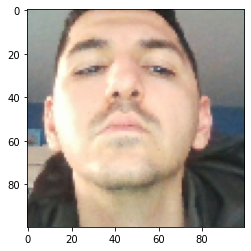

In [20]:
plt.imshow(samp[0])

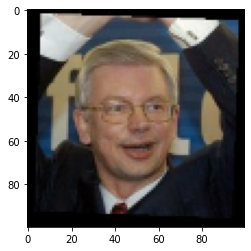

In [21]:
plt.imshow(samp[1])

In [22]:
samp[2]

0.0

In [23]:
# train set
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [25]:
train_samples= train_data.as_numpy_iterator()
train_sample = train_samples.next()


In [26]:
# test set
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data  = test_data.batch(16)
test_data = test_data.prefetch(8)

create embedding layer

In [27]:
def make_embedding():
    # First layer
    inp = Input(shape= (100,100,3), name = 'input_image')
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    maxpool1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    
    # Second layer
    c2 = Conv2D(128,(7,7), activation='relu')(maxpool1)
    maxpool2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    # Third layer
    c3 = Conv2D(128,(4,4), activation='relu')(maxpool2)
    maxpool3 = MaxPooling2D(64,(2,2),padding='same')(c3)

    # Final layer
    c4 = Conv2D(256,(4,4), activation='relu')(maxpool3)
    f1 = Flatten()(c4)
    d1= Dense(4096,activation='sigmoid')(f1)


    return Model(inputs =[inp] , outputs=[d1], name='embedding')

In [28]:
embedding = make_embedding()

Here are the shapes of the architecture

In [29]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

Distance layer

In [30]:
# Siamese class for measuring the distance using similarity calculation between anchor embedding and validation(pos/neg images) embedding 

class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [31]:
# l1 = L1Dist()

In [32]:
# l1(anchor_embedding, validation_embedding)

create siamese model

In [33]:
input_image = Input(name= 'input_img', shape = (100,100,3))
validation_image = Input(name= 'validation_img', shape = (100,100,3))

In [34]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [35]:
siamese_layer = L1Dist()

In [36]:
distances = siamese_layer(inp_embedding,val_embedding)

In [37]:
def create_siamese_model():
    # anchor image in the network
    input_image = Input(name = 'input_img',shape=(100,100,3))

#   validation image in the network
    validation_image = Input(name = 'validation_img',shape=(100,100,3))

    # combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image)) 

    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs = [input_image,validation_image], outputs = classifier, name = "Siamese_Network" )

In [38]:
siamese_model = create_siamese_model() 

In [39]:
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

Loss function and set up an optimizer


In [40]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [41]:
opt = tf.keras.optimizers.Adam(1e-4)

establish checkpoints

In [42]:
checkpoint_dir = '/.training_checkpoints'
checkpoints_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

custom training step

In [43]:
#  this step is focused on training for one batch

@tf.function
def train_step(batch):
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # get anchor and pos/neg image
        X = batch[:2]
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X,training = True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    #  calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [47]:
from tqdm import tqdm


create a training loop 

In [48]:
#  iterate over every batch in the dataset
def train(data, EPOCHS):
    # loop through the epoch
    for epoch in tqdm(range(1, EPOCHS + 1)):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        # progbar = tf.keras.utils.Progbar(len(data))

        #  loop through each batch
        for idx, batch in enumerate(data):
            # run train step here
            train_step(batch)
            # progbar.update(idx+1)
        # save checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoints_prefix)

train the model

In [49]:
EPOCHS = 50

In [50]:
train(train_data,EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]


 Epoch 1/50


  0%|          | 0/50 [00:55<?, ?it/s]


KeyboardInterrupt: 